In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cd /content/drive/MyDrive/CustomerSeg/

In [ ]:
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 59.7MB/s]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [4]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/CustomerSeg/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Prepare features and target
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)



In [5]:
# Define categorical and numeric columns
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Convert TotalCharges to numeric and handle missing values
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
df[numeric_columns] = df[numeric_columns].astype(float)
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
X['TotalCharges'].fillna(0, inplace=True)
X[numeric_columns] = X[numeric_columns].astype('float32')
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),  # Apply StandardScaler to numeric columns
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Apply OneHotEncoder to categorical columns
    ])

# Create and apply preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_processed = pipeline.fit_transform(X)


In [6]:
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),  # Apply StandardScaler to numeric columns
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Apply OneHotEncoder to categorical columns
    ])

# Create and apply preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X = pipeline.fit_transform(X)

<ipython-input-7-15ff21fef374>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


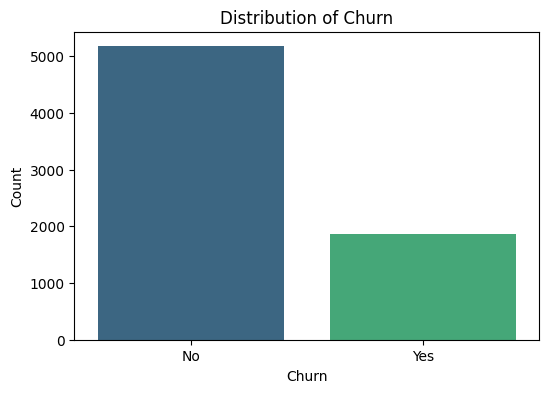

In [7]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='viridis')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

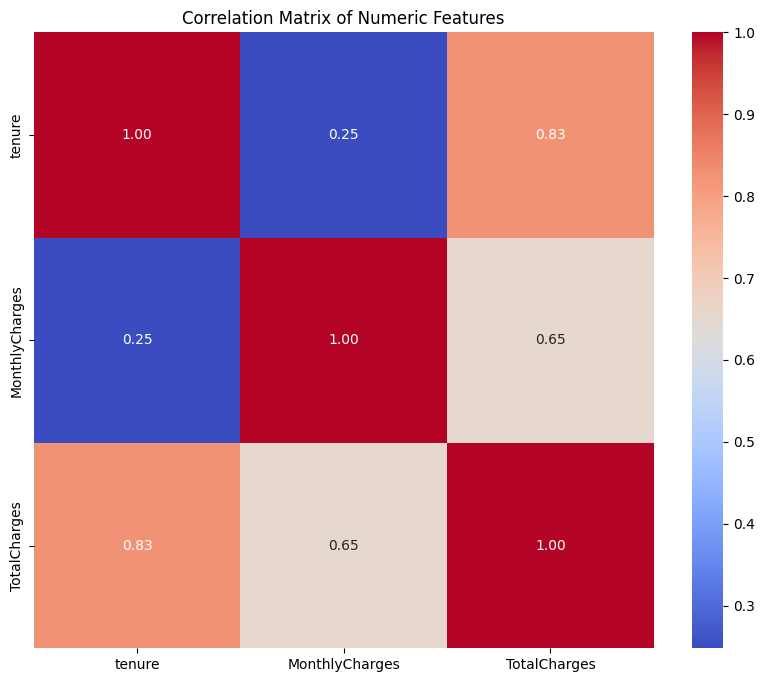

In [8]:
correlation_matrix = df[numeric_columns].corr()
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Fit RandomForestClassifier to get feature importances
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Select important features
sfm = SelectFromModel(rf_model, threshold='mean')
X_selected = sfm.transform(X)

# Get the names of selected features
selected_features = sfm.get_support(indices=True)
encoded_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns)
feature_names = np.concatenate([numeric_columns, encoded_feature_names])
selected_feature_names = feature_names[selected_features]
print(f"Selected features: {selected_feature_names}")

Selected features: ['tenure' 'MonthlyCharges' 'TotalCharges' 'InternetService_Fiber optic']


In [11]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Ensure correct shape
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define a simple neural network
class ChurnNN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = ChurnNN(input_dim)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 1000
batch_size = 32

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print the loss for every epoch
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()

# Calculate accuracy
accuracy = (y_pred_class == y_test_tensor).float().mean()
print(f'Accuracy on test set: {accuracy:.4f}')

Epoch [5/1000], Loss: 0.6719
Epoch [10/1000], Loss: 0.6484
Epoch [15/1000], Loss: 0.6266
Epoch [20/1000], Loss: 0.6054
Epoch [25/1000], Loss: 0.5836
Epoch [30/1000], Loss: 0.5624
Epoch [35/1000], Loss: 0.5426
Epoch [40/1000], Loss: 0.5247
Epoch [45/1000], Loss: 0.5094
Epoch [50/1000], Loss: 0.4970
Epoch [55/1000], Loss: 0.4877
Epoch [60/1000], Loss: 0.4807
Epoch [65/1000], Loss: 0.4754
Epoch [70/1000], Loss: 0.4712
Epoch [75/1000], Loss: 0.4675
Epoch [80/1000], Loss: 0.4643
Epoch [85/1000], Loss: 0.4614
Epoch [90/1000], Loss: 0.4588
Epoch [95/1000], Loss: 0.4566
Epoch [100/1000], Loss: 0.4547
Epoch [105/1000], Loss: 0.4530
Epoch [110/1000], Loss: 0.4515
Epoch [115/1000], Loss: 0.4502
Epoch [120/1000], Loss: 0.4491
Epoch [125/1000], Loss: 0.4482
Epoch [130/1000], Loss: 0.4474
Epoch [135/1000], Loss: 0.4468
Epoch [140/1000], Loss: 0.4462
Epoch [145/1000], Loss: 0.4457
Epoch [150/1000], Loss: 0.4453
Epoch [155/1000], Loss: 0.4449
Epoch [160/1000], Loss: 0.4446
Epoch [165/1000], Loss: 0.44

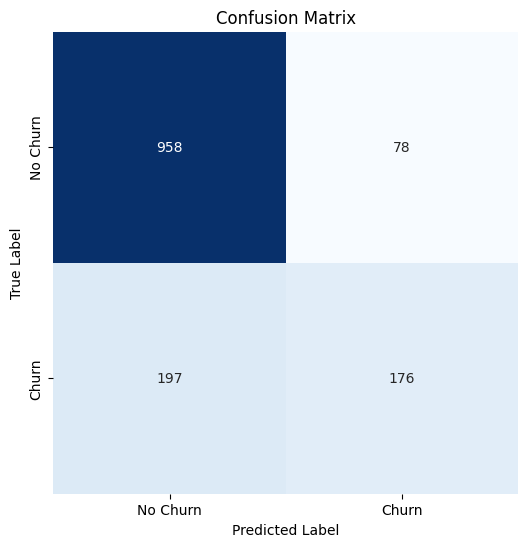

In [13]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()

# Confusion matrix
cm = confusion_matrix(y_test_tensor, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

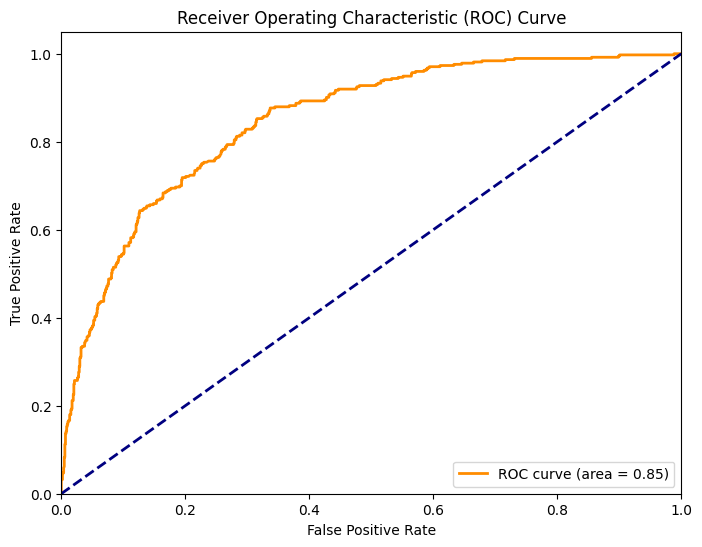

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_tensor, y_pred)
roc_auc = roc_auc_score(y_test_tensor, y_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()